
# Central Ingestion Hub
### 01 - Multi-Source Document Ingestion, Merging & Chunking (ESG/Biodiversity)



Notebook Overview

This notebook performs multi-source document ingestion and preprocessing for ESG and biodiversity-related content.

It loads documents from:
- 📄 **PDFs** stored locally
- 🌐 **Web URLs** from authoritative biodiversity sites
- 📊 **CSV files** (e.g., firm-level biodiversity scores)

Using the **LlamaIndex** framework, it:
- Merges multi-page PDFs into single documents
- Preserves web and CSV entries without overwriting
- Applies controlled, overlapping **chunking** (1024-character windows with 200-character overlap)
- Prepares the data for downstream tasks like vector indexing and LLM-based Q&A.

Output: A list of cleaned, semantically chunked `Document` nodes ready for embedding in `02_build_vector_index.ipynb`.


### Install required packages
```bash
pip install llama-index chromadb PyMuPDF python-dotenv
```

In [1]:
from llama_index.core import SimpleDirectoryReader
from llama_index.readers.web import SimpleWebPageReader
from llama_index.readers.file import PandasCSVReader
from pathlib import Path
import os
from dotenv import load_dotenv
from llama_index.core.schema import Document
from llama_index.core.node_parser import SimpleNodeParser

load_dotenv()

True

### Multi-Source Document Ingestion, Merging, and Chunking

In [2]:
def load_all_documents(
    pdf_path: Path,
    url_list: list = None,
    csv_paths: list = None
):
    
    """
    Load ESG/Biodiversity documents from multiple sources into a unified list.

    Supported sources:
    - 📄 Local PDF documents (merged by file)
    - 🌐 Web URLs (via SimpleWebPageReader)
    - 📊 CSV files (via PandasCSVReader)

    Args:
        pdf_path (Path): Directory containing PDF files.
        url_list (list, optional): List of URLs to fetch and parse.
        csv_paths (list, optional): List of CSV file paths to load.

    Returns:
        List[Document]: A unified list of LlamaIndex Document objects from all sources,
                        ready for merging, chunking, and downstream processing.
    """
    
    all_documents = []

    # Load PDFs
    pdf_docs = SimpleDirectoryReader(
        input_dir=pdf_path,
        recursive=False,
        required_exts=[".pdf"],
        file_extractor={'pdf': 'pymupdf'},
        filename_as_id=True
    ).load_data()
    print(f"Loaded {len(pdf_docs)} PDF docs.")
    all_documents.extend(pdf_docs)

    # Load URLs
    if url_list:
        web_docs = SimpleWebPageReader().load_data(urls=url_list)
        print(f"Loaded {len(web_docs)} web pages.")
        all_documents.extend(web_docs)

    # Load CSVs
    if csv_paths:
        csv_reader = PandasCSVReader()
        for csv_path in csv_paths:
            csv_docs = csv_reader.load_data(Path(csv_path))
            print(f"Loaded {len(csv_docs)} docs from {csv_path}")
            all_documents.extend(csv_docs)

    return all_documents

# Define paths and sources
pdf_path = Path("../data/raw")
url_list = [
    "https://www.unep.org/resources/report/state-finance-biodiversity",
    "https://www.cdp.net/en/research/global-reports/global-biodiversity-report-2023",
    "https://ipbes.net/global-assessment",
    "https://wwf.panda.org/discover/knowledge_hub/all_publications/living_planet_report_2022/",
    "https://environment.ec.europa.eu/strategy/biodiversity-strategy-2030_en"
]

csv_paths = [
    "10k_biodiversity_scores.csv"  # Adjust path as needed, or leave as []
]


# Load documents from all sources
documents = load_all_documents(pdf_path, url_list, csv_paths)
print(f"📚 Total documents loaded: {len(documents)}")


# 🔹 2️⃣ Merge multiple pages into a single document per file
# 🔹 2️⃣ Merge PDF pages by filename; keep web and CSV docs intact
merged_documents = {}

for doc in documents:
    file_name = doc.metadata.get("file_name")
    
    if file_name:  # Treat only PDFs this way
        if file_name not in merged_documents:
            merged_documents[file_name] = Document(text=doc.text, metadata=doc.metadata)
        else:
            merged_documents[file_name] = Document(
                text=merged_documents[file_name].text + "\n" + doc.text,
                metadata=merged_documents[file_name].metadata
            )
    else:
        # Web pages or CSVs (no filename) — use fallback key to prevent overwrite
        fallback_key = doc.metadata.get("source", f"source_{len(merged_documents)}")
        merged_documents[fallback_key] = doc


# Convert dictionary back to a list of single-document PDFs
documents = list(merged_documents.values())

print(f"Loaded {len(documents)} full documents.") 

# Apply controlled chunking: break docs into 3-sentence segments
parser = SimpleNodeParser.from_defaults(
    chunk_size=1024,      # Target ~1024 characters
    chunk_overlap=200     # Allow 200 characters of overlap to retain context
)

chunked_documents = [parser.get_nodes_from_documents([doc]) for doc in documents]
flattened_docs = [node for sublist in chunked_documents for node in sublist]

print(f"Chunked into {len(chunked_documents)} total chunks.")

Loaded 562 PDF docs.
Loaded 5 web pages.
Loaded 1 docs from 10k_biodiversity_scores.csv
📚 Total documents loaded: 568
Loaded 17 full documents.
Chunked into 17 total chunks.


### Preview the first few chunks

In [3]:
# Preview first few
# Step 5: Preview first few chunks
for i, chunk in enumerate(flattened_docs[:5]):
    print(f"\n📄 Chunk {i+1} (From: {chunk.metadata.get('file_name', 'Unknown')})")
    print(chunk.text[:500])
    print('-' * 50)


📄 Chunk 1 (From:  How investors and corporates are approaching natural capital _ LinkedIn.pdf)
Critical thinking13,427 subscribers Subscribed
How investors and corporates areapproaching natural capital
Mercer - Investments36,369 followers
September 27, 2024
Cara Williams, Global Head of ESG, Climate and Sustainability
As the sustainability agenda evolves, corporates and investors alike aregrappling with the complexity of valuing natural capital. The transitionfrom the Taskforce on Climate-related Financial Disclosures (TCFD) tothe Taskforce on Nature-related Financial Disclosures (TNFD) i
--------------------------------------------------

📄 Chunk 2 (From:  How investors and corporates are approaching natural capital _ LinkedIn.pdf)
The first step towards TNFD alignment is measurement. Investors andcorporates can undertake an initial health check of their portfolio and/oroperations to understand areas in which their investments and/oroperations are negatively impacting natural capital

## Visualizing Chunk Distribution

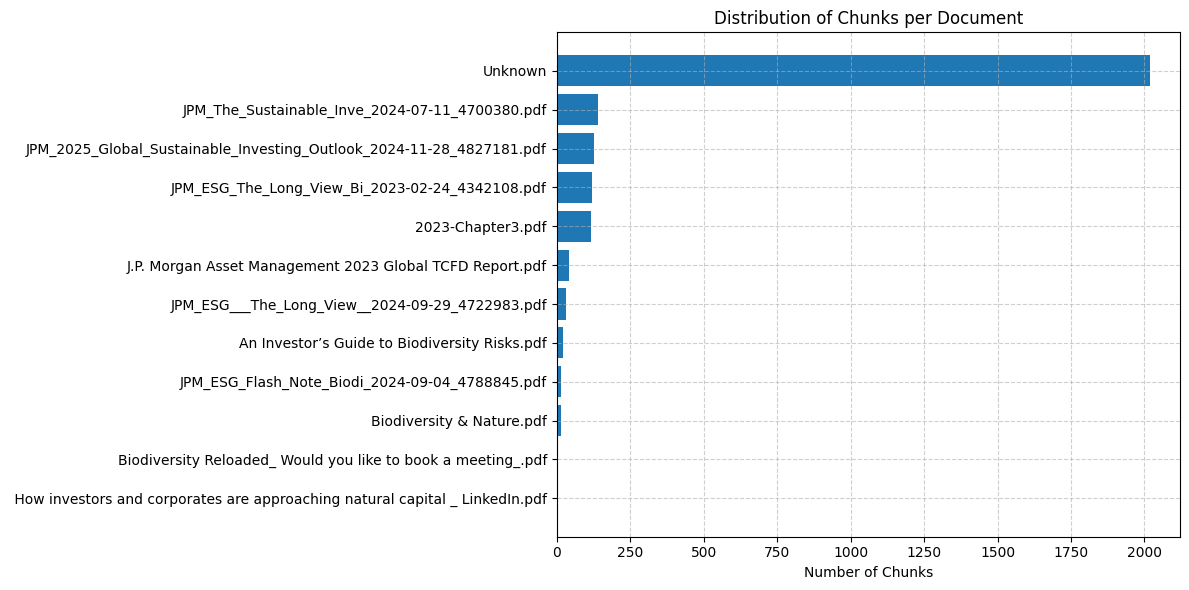

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract source names from metadata
source_labels = []
for node in flattened_docs:
    source = node.metadata.get("file_name") or node.metadata.get("source") or "Unknown"
    source_labels.append(source)

# Count chunks per document
chunk_counts = Counter(source_labels)
top_sources = chunk_counts.most_common(15)  # Top N sources for readability

# Plot
plt.figure(figsize=(12, 6))
plt.barh(
    [k for k, _ in top_sources],
    [v for _, v in top_sources]
)
plt.xlabel("Number of Chunks")
plt.title("Distribution of Chunks per Document")
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
import pickle

# Define output directory
output_dir = Path("../outputs")
output_dir.mkdir(parents=True, exist_ok=True)  # Create directory if not exists

# Save the chunked documents
flattened_docs_path = output_dir / "flattened_docs.pkl"
with open(flattened_docs_path, "wb") as f:
    pickle.dump(flattened_docs, f)

print(f"Saved chunked documents: {flattened_docs_path}")


Saved chunked documents: ../outputs/flattened_docs.pkl


In [6]:
import os
print(os.listdir("../outputs/"))


['flattened_docs.pkl']
